# Data Analysis
Write a Jupyter Notebook called AnalyticalWork.ipynb with your answers to the
following exercises/questions.

In [75]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [76]:
con = sqlite3.connect(r"../laliga.sqlite")
df = pd.read_sql_query("SELECT * FROM Matches", con)

# Data formatting:
# We split the "date" column into the corresponding columns, and specify the correct formatting.
# This way we avoid the year 29 or higher to be mistaken by 2029 (error with to_datetime function).
df[["month", "day", "year"]] = df["date"].str.split("/", 2, expand = True)
df["year"] = df["year"].apply(lambda x: f"19{x}" if int(x) >= 23 else f"20{x}")
df['datetime'] = pd.to_datetime(df["date"] + ' ' + df["time"])
df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day))
df = df.drop(["month", "day", "year"], axis = 1)

# We also change the formatting of the time to be in 24h format
# df['time'] = df["time"].apply(lambda x: datetime.strftime(datetime.strptime(x, "%I:%M %p"), "%H:%M") if type(x) == str else x)
df.head()

,season,division,matchday,date,time,home_team,away_team,score,datetime
0,1928-1929,1,1,1929-02-10,None,Arenas Club,Athletic Madrid,2:3,NaT
1,1928-1929,1,1,1929-02-10,None,Espanyol,Real Unión,3:2,NaT
2,1928-1929,1,1,1929-02-10,None,Real Madrid,Catalunya,5:0,NaT
3,1928-1929,1,1,1929-02-10,None,Donostia,Athletic,1:1,NaT
4,1928-1929,1,1,1929-02-12,None,Racing,Barcelona,0:2,NaT


1. Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or
there’s a tie) of all matches in the row. Write in the plot the percentage of
each category.

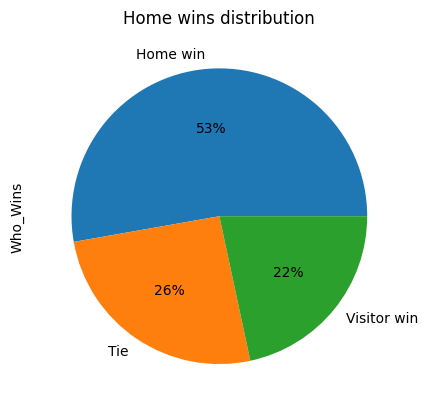

In [77]:
df[["home_goals", "away_goals"]] = df["score"].str.split(":", expand=True).astype(float)
df2=df.dropna(subset = "score") 
#
# Danger: dropna deletes all rows where the time is not specified. I would do dropna for the specified column when needed.
#
df2["goal diff"] = (df2["home_goals"]  - df2["away_goals"])
df2["Who_Wins"] = np.where(df2["goal diff"] > 0, "Home win", np.where(df2["goal diff"] < 0, "Visitor win", "Tie"))
home_wins_count = df2["Who_Wins"].value_counts()
ax = home_wins_count.plot(kind = 'pie', autopct = '%1.0f%%')
ax.set_title("Home wins distribution")
plt.show()

2. What are the top ten scoring teams of all time? What are the ten teams
that concede the most? Make two bar plot charts showing each of them.
Consider only matches played in 1st division.
What have been the biggest wins? Of course, when we say biggest we mean
those with the highest goal difference. Show the top ten of them in a table.

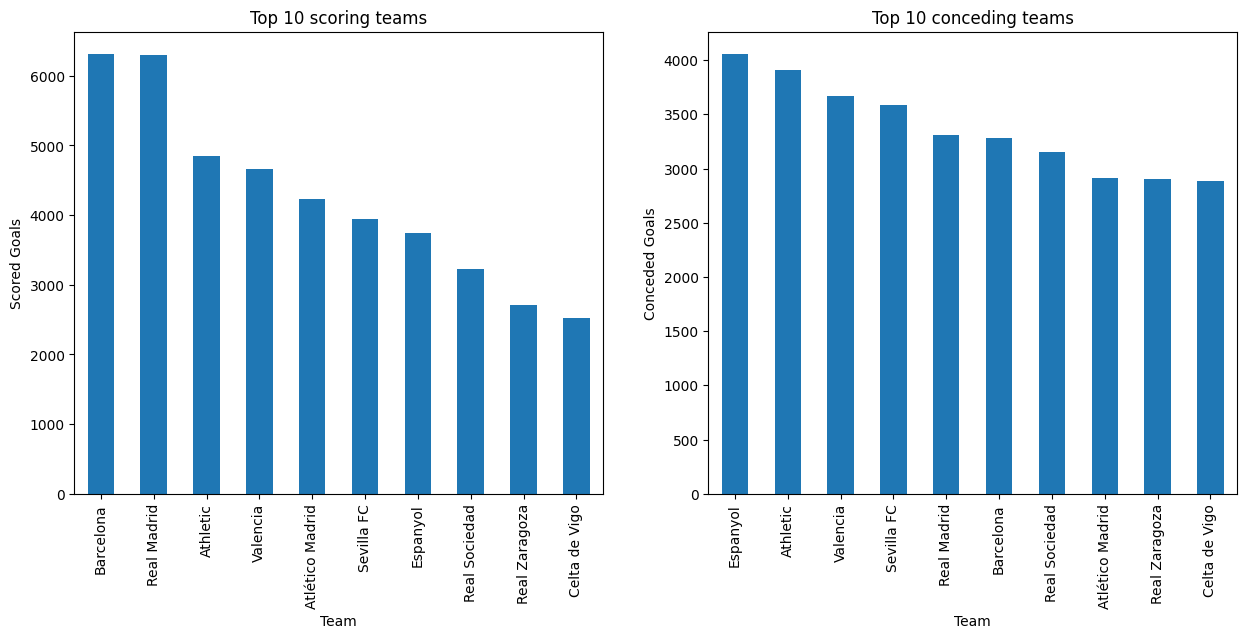

In [78]:
first_division = df2[df2.division == 1]
scored_goals = first_division.pivot_table('home_goals', 'home_team', aggfunc=np.sum)
scored_goals['away_goals'] = first_division.pivot_table('away_goals', 'away_team', aggfunc=np.sum)
scored_goals['total_goals'] = scored_goals['away_goals'] + scored_goals['home_goals']
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
ax = scored_goals['total_goals'].sort_values(ascending=False).head(10).plot(kind='bar')
ax.set_title('Top 10 scoring teams')
ax.set_ylabel('Scored Goals')
ax.set_xlabel('Team')
conceded_goals = first_division.pivot_table('home_goals', 'away_team', aggfunc=np.sum)
conceded_goals['away_goals'] = first_division.pivot_table('away_goals', 'home_team', aggfunc=np.sum)
conceded_goals['total_goals'] = conceded_goals['away_goals'] + conceded_goals['home_goals']
plt.subplot(1, 2, 2)
ax2 = conceded_goals['total_goals'].sort_values(ascending=False).head(10).plot(kind='bar')
ax2.set_title('Top 10 conceding teams')
ax2.set_xlabel('Team')
ax2.set_ylabel('Conceded Goals')
plt.show()

In [79]:
first_division['abs_diff'] = abs(first_division['goal diff'])
biggest_wins = first_division.sort_values('abs_diff', ascending = False).head(10)
print("Top 10 biggest wins:")
biggest_wins[['season', 'date', 'home_team', 'away_team', 'score', 'goal diff']]

Top 10 biggest wins:


,season,date,home_team,away_team,score,goal diff
225,1930-1931,1931-02-08,Athletic,Barcelona,12:1,11.0
936,1940-1941,1940-09-29,Sevilla FC,Barcelona,11:1,10.0
1168,1941-1942,1942-01-11,Athletic,Celta de Vigo,10:0,10.0
2787,1950-1951,1950-11-19,Athletic,Lérida,10:0,10.0
1071,1941-1942,1941-09-28,Sevilla FC,Real Oviedo,10:0,10.0
2574,1949-1950,1949-10-23,Celta de Vigo,Gimnàstic,10:1,9.0
2771,1950-1951,1950-11-05,Dep. La Coruña,Lérida,10:1,9.0
4745,1958-1959,1958-12-28,Athletic,Real Gijón,9:0,9.0
2969,1951-1952,1951-09-23,Athletic,Real Zaragoza,10:1,9.0
2537,1949-1950,1949-09-11,Barcelona,Gimnàstic,10:1,9.0


3. There has been a lot of discussion about how LaLiga’s television rights have
changed game schedules in the last years. Make a bar plot chart showing
the number of matches played each weekday, and make also a histogram
of match time. Compare this two graphics between seasons 2000-2001 and
2020-2021.

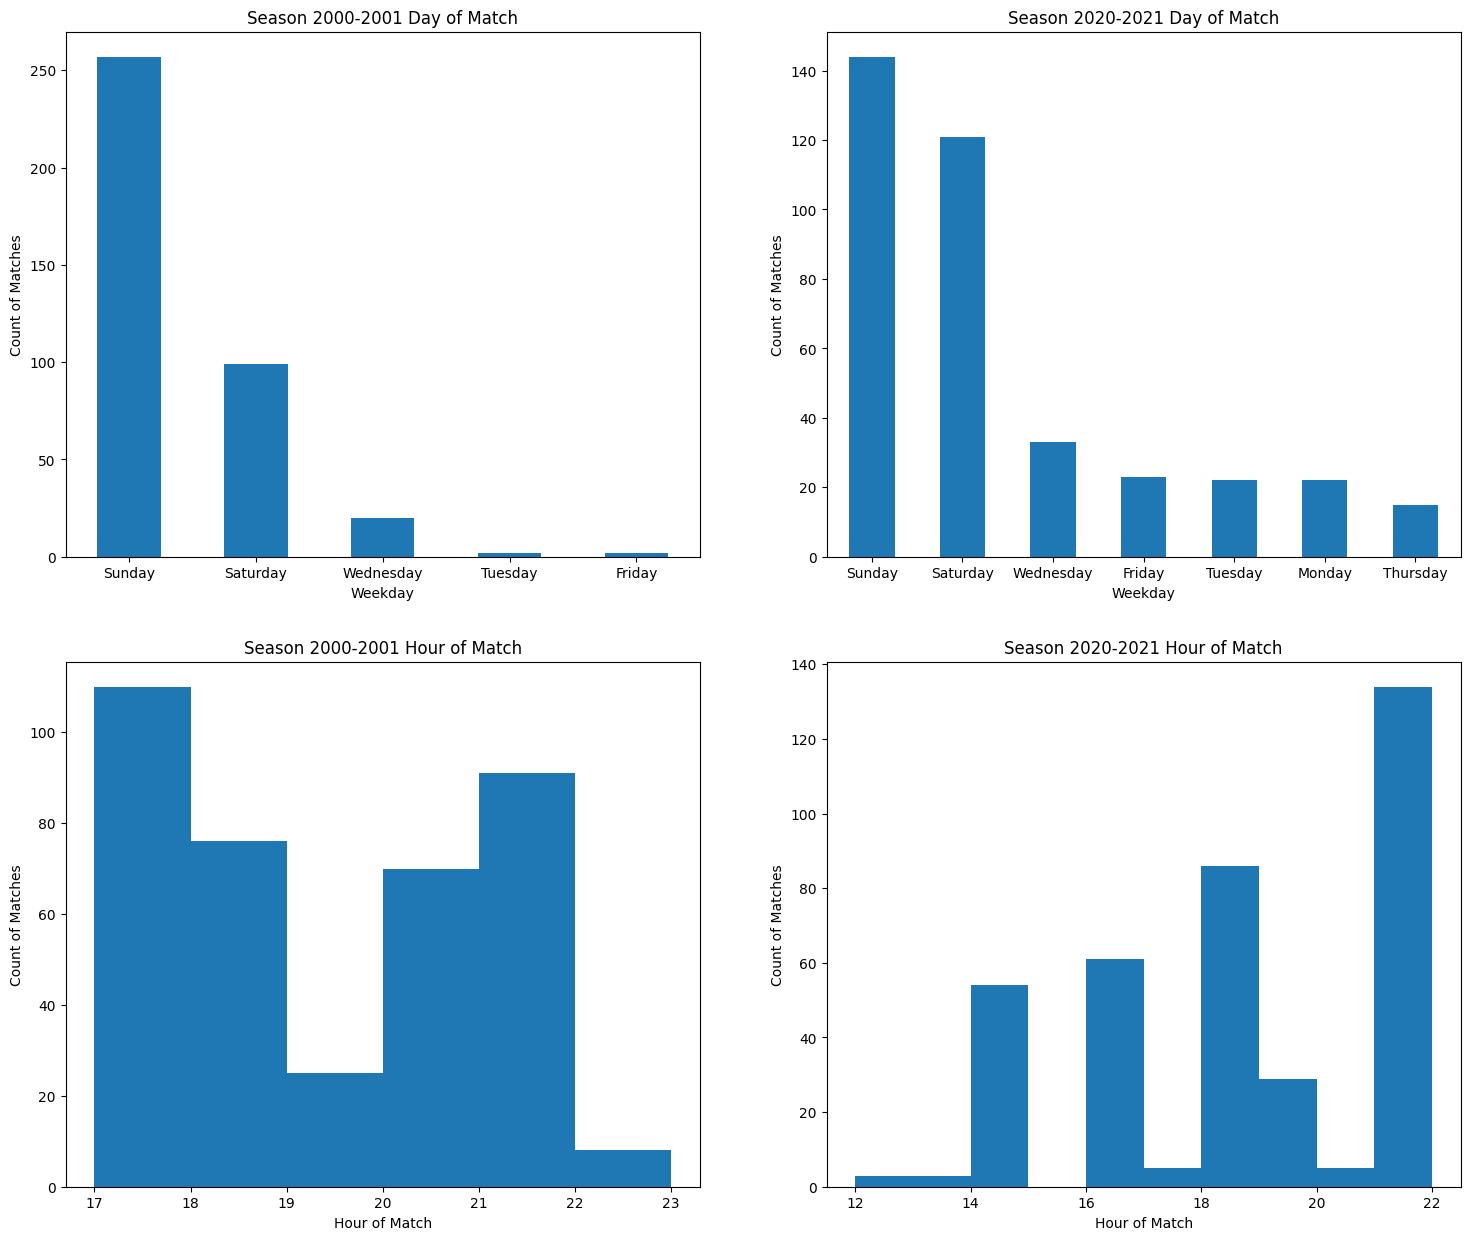

In [80]:
# Check error: AttributeError: Can only use .dt accessor with datetimelike values
# Changes to time formatting! We can keep an original time format column and a stylized one.
season_00_01 = first_division[first_division.season == '2000-2001']
season_00_01['weekday'] = season_00_01['date'].dt.day_name()
season_20_21 = first_division[first_division.season == '2020-2021']
season_20_21['weekday'] = season_20_21['date'].dt.day_name()
plt.figure(figsize=(18,15))
plt.subplot(2,2,1)
season_00_01_plot = season_00_01['weekday'].value_counts().plot(kind = 'bar')
season_00_01_plot.set_title('Season 2000-2001 Day of Match')
season_00_01_plot.set_xlabel('Weekday')
season_00_01_plot.tick_params(axis='x', labelrotation = 0)
season_00_01_plot.set_ylabel('Count of Matches')
plt.subplot(2,2,3)
plt.hist(season_00_01['datetime'].dt.hour, bins = np.arange(17, 24))
plt.title('Season 2000-2001 Hour of Match')
plt.xlabel('Hour of Match')
plt.ylabel('Count of Matches')
plt.subplot(2,2,2)
season_20_21_plot = season_20_21['weekday'].value_counts().plot(kind = 'bar')
season_20_21_plot.set_title('Season 2020-2021 Day of Match')
season_20_21_plot.tick_params(axis='x', labelrotation = 0)
season_20_21_plot.set_xlabel('Weekday')
season_20_21_plot.set_ylabel('Count of Matches')
plt.subplot(2,2,4)
plt.hist(season_20_21['datetime'].dt.hour)
plt.title('Season 2020-2021 Hour of Match')
plt.xlabel('Hour of Match')
plt.ylabel('Count of Matches')
plt.show()

4. Build a cross results table for season 2020-2021. Figure 1 is an example taken
from Wikipedia. Try to make it the most similar to this one: use team abbreviations as column names and paint the background of each cell according
to result (green in case local team wins and red in case visitor team wins).
Also, could you model the intensity of this background color with the goal
difference from the match?
Write a function that, given the season, plots the cross results table. Function prototype should be like plot_cross_results_table(season) and return the plot object.


In [81]:
def abreviate_names(team_names):
    """Abreviates to 3 letters the name of football teams passed in a list.

    Args:
        team_names (string): name of the teams.

    Returns:
        list(str): 3 letter abreviations for each team.
    """
    abreviations = {}
    for team in team_names:
        words = team.split()
        if words[0] == 'Real':
            abreviations[team] = 'R' + words[1][0:2].upper()
        elif len(words[0])<3:
            abreviations[team] = words[1][0:3].upper()
        else:
            abreviations[team] = words[0][0:3].upper()
    return abreviations

In [82]:
def style_scores(score):
    """Styles values of a dataframe with format 'int:int'. Style format is green if the first integer is greater than the second, red if smaller and yellow if equal. Opacity of each cell is modullated by the difference of the two int.

    Args:
        score (str): result of a match with format 'int:int'. Example: '1:2'

    Returns:
        str: style settings for the cell
    """
    if score == '-': return 'text-align: center'
    else:
        home_goals, away_goals = score.split(":")
        goal_diff = int(home_goals) - int(away_goals)
        if goal_diff < 0:
            return f'background-color:red; opacity: {abs(goal_diff)*20}%; color: white; text-align: center'
        elif goal_diff > 0:
            return f'background-color:green; opacity: {abs(goal_diff)*20}%; text-align: center'
        else:
            return 'background-color:#FFF380; color: black; text-align: center'

In [83]:
def plot_cross_results_table(season, division):
    """Makes a cross-table showing the results of the input season and league.

    Args:
        season (str): season of the results to make the table from. Format: 'aaaa-aaaa'. Example: '2000-2001'.
        division (int): division of the results to make the table from. Ex: 1

    Returns:
        pandas.io.formats.style.Styler: crosstable with the match results.
    """
    df = df2[df2.division == division]
    df = df[df2.season == season]
    team_names = df.away_team.drop_duplicates()
    df = df.replace({'away_team':abreviate_names(team_names)})
    table = pd.crosstab(df.home_team, df.away_team, rownames=['Home Team'], colnames=['Away Team'], values=df.score, aggfunc='first')
    table = table.fillna('-')
    ordered_columns = abreviate_names(table.index).values()
    table =  table[ordered_columns].style.applymap(style_scores)
    return table
plot_cross_results_table('2010-2011', 1)


Away Team,ATH,ATL,BAR,OSA,DEP,ESP,GET,HÉR,LEV,MÁL,RCD,RAC,RMA,RSO,RZA,SEV,SPO,ALM,VAL,VIL
Home Team,,,,,,,,,,,,,,,,,,,,
Athletic,-,1:2,1:3,1:0,1:2,2:1,3:0,3:0,3:2,1:1,3:0,2:1,0:3,2:1,2:1,2:0,3:0,1:0,1:2,0:1
Atlético Madrid,0:2,-,1:2,3:0,2:0,2:3,2:0,2:1,4:1,0:3,3:0,0:0,1:2,3:0,1:0,2:2,4:0,1:1,1:2,3:1
Barcelona,2:1,3:0,-,2:0,0:0,2:0,2:1,0:2,2:1,4:1,1:1,3:0,5:0,5:0,1:0,5:0,1:0,3:1,2:1,3:1
CA Osasuna,1:2,2:3,0:3,-,0:0,4:0,0:0,3:0,1:1,3:0,1:1,3:1,1:0,3:1,0:0,3:2,1:0,0:0,1:0,1:0
Dep. La Coruña,2:1,0:1,0:4,0:0,-,3:0,2:2,1:0,0:1,3:0,2:1,2:0,0:0,2:1,0:0,3:3,1:1,0:2,0:2,1:0
Espanyol,2:1,2:2,1:5,1:0,2:0,-,3:1,3:0,2:1,1:0,1:2,1:2,0:1,4:1,4:0,2:3,1:0,1:0,2:2,0:1
Getafe,2:2,1:1,1:3,2:0,4:1,1:3,-,3:0,4:1,0:2,3:0,0:1,2:3,0:4,1:1,1:0,3:0,2:0,2:4,1:0
Hércules CF,0:1,4:1,0:3,0:4,1:0,0:0,0:0,-,3:1,4:1,2:2,2:3,1:3,2:1,2:1,2:0,0:0,1:2,1:2,2:2
Levante,1:2,2:0,1:1,2:1,1:2,1:0,2:0,2:1,-,3:1,1:1,3:1,0:0,2:1,1:2,1:4,0:0,1:0,0:1,1:2


5. As you surely know, there has always been a historical rivalry between
Barcelona and Real Madrid. But which of them has won the most games
in direct confrontations? Which of them has scored the most goals in these
games? Show both things in two pie charts, side by side. Remember to consider ties in the first one.
Write a function that, given two team names, plots the two graphs described
above. Function prototype should be like plot_direct_confrontations_stats(team1, team2) and return the plot object. Use it with some other
classical rivals like Betis and Sevilla.

In [1]:
Team1 = "Barcelona"
Team2 = "Real Madrid"

df3 = df2.loc[((df2["home_team"] == Team2) & (df2["away_team"] == Team1)) | ((df2["home_team"] == Team1) & (df2["away_team"] == Team2))]
df3["Winner"] = np.where(df3["goal diff"] > 0, df3.home_team.values, np.where(df3["goal diff"] < 0, df3.away_team.values, "tie"))
direct_confrontation_count = df3["Winner"].value_counts()
ax = direct_confrontation_count.plot(kind = "pie", autopct = '%1.0f%%')
ax.set_title("Direct confrontation results")
plt.show()

#SCORED GOALS PER TEAM
scored_goals['home_goals'] = df3.pivot_table('home_goals', 'home_team', aggfunc=np.sum)
scored_goals['away_goals'] = df3.pivot_table('away_goals', 'away_team', aggfunc=np.sum)
scored_goals['total_goals'] = scored_goals['away_goals'] + scored_goals['home_goals']

ax = scored_goals['total_goals'].sort_values().plot(kind='pie', autopct = '%1.0f%%')
ax.set_title('Goals result')
plt.show()


NameError: name 'df2' is not defined

6. Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games
without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the
longest undefeated streaks in a horizontal bar plot, indicating in each bar
the team name and the dates it held that streak, for instance, Real Sociedad
22/04/1979 - 04/05/1980.

In [84]:
streaks_dic = {}
team_lst = df["home_team"].unique()

for team in team_lst:
    current_streak = 0
    max_streak = 0
    home_games = df2[df2["home_team"] == team]
    away_games = df2[df2["away_team"] == team]
    total_games = pd.concat([home_games, away_games])
    sorted_games = total_games.sort_values(by = "date")
    for index, row in sorted_games.iterrows():
        no_loss = (team == row["home_team"] and row["goal diff"] > -1) or (team == row["away_team"] and row["goal diff"] < 1)
        if no_loss == True:
            current_streak += 1
        else:
            if current_streak > max_streak:
                max_streak = current_streak
                true_st_date = st_date
                end_date = row["date"]
            current_streak = 0
        if current_streak == 1:
            st_date = row["date"]
    if max_streak == 0:
        streaks_dic[team] = [max_streak, "NA", "NA"]
    else:
        streaks_dic[team] = [max_streak, datetime.strftime(true_st_date, '%d/%m/%Y'), datetime.strftime(end_date, '%d/%m/%Y')]

sorted_streaks = dict(sorted(streaks_dic.items(), key=lambda item: item[1], reverse = True))
print(sorted_streaks)

{'Barcelona': [43, '15/04/2017', '13/05/2018'], 'Real Sociedad': [38, '29/04/1979', '11/05/1980'], 'Real Madrid': [31, '08/05/1988', '15/04/1989'], 'Real Valladolid': [29, '07/10/2006', '06/05/2007'], 'Atlético Madrid': [26, '08/02/2020', '12/12/2020'], 'Sporting Gijón': [25, '10/05/2014', '18/01/2015'], 'Espanyol': [22, '17/10/1993', '20/03/1994'], 'Valencia': [22, '13/12/1970', '06/03/1971'], 'Dep. La Coruña': [22, '06/03/1994', '19/11/1994'], 'UD Las Palmas': [21, '04/10/1997', '14/02/1998'], 'CD Castellón': [20, '28/03/1971', '05/12/1971'], 'UD Salamanca': [20, '19/01/1997', '31/08/1997'], 'Athletic': [20, '16/06/1929', '07/12/1930'], 'CD Numancia': [20, '12/04/1998', '06/12/1998'], 'Real Zaragoza': [18, '28/02/2009', '12/09/2009'], 'RCD Mallorca': [18, '27/01/1996', '08/09/1996'], 'Sevilla FC': [18, '16/02/2020', '17/10/2020'], 'Albacete': [18, '12/01/2003', '17/05/2003'], 'Real Betis': [17, '31/01/1971', '05/09/1971'], 'SD Eibar': [17, '25/09/1994', '12/02/1995'], 'Málaga CF': [1

7. Create a table with the final standings of each season (and division), that
is, a table that contains all the teams ordered (in descending order) by the
number of points they got during that season, and some other aggregate
statistics. The table must contain the following columns: season, division,
ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals
difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none
for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of
1st division come before standings of 2nd division. Save the final table in Excel with the name SeasonStandings.xlsx in the
reports/ folder.


8. Villarreal is a team that has grown a lot in recent decades. Specially ever
since some billionaire guy bought it (Fernando Roig, from Mercadona).
Make a line plot showing the rank of Villarreal at the end of each season,
from the oldest ones (left) to the earliest ones (right). Consider rankings in
2nd division to be a continuation of the 1st one, that is, if there’s N teams in
1st division and Villarreal got r position in 2nd division, then it should be
placed in N + r. Draw in the same plot a line showing the cut between 1st
and 2nd division.
Write a function that, given n team names, plots the graph described above
of each one of them superposed. Function prototype should be like plot_ranking_evolution(team1, team2, ..., teamN) and return the plot object (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all Catalan teams in the data

9. In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the most elevator teams in LaLiga? Plot the history of the top 5 of them using the function from exercise 8.

10. Create a table that is the same as the one in exercise 7, but not only with
the season final standings, but the standings at the end of each matchday.
Columns are the same, including matchday that tells about which match-day from the season these standings are from. Would you be able to add a
new column last_5 with the result of last 5 matches? This column should
contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is
the immediate previous match, the second one is the match before this one,
and so on. If there are no 5 previous matches (because matchday < 6, for
instance) then just make the list shorter.
Save the final table in Excel with the name MatchdayStandings.xlsx in the
reports/ folder.